## SENTIMENT ANALISYS IN PORTUGUESE

### SENTIMENT ANALYSIS OF TEXTS IN PORTUGUESE USING NATURAL LANGUAGE PROCESSING TECHNIQUES
Running locally
Using some Linux distro and make sure you have Python 3 installed.

Clone the project:

```bash 
git clone https://github.com/lucasma7/sentiment_analisys_in_portuguese.git 
```
Access the project directory:

  cd sentiment_analisys_in_portuguese
Add a model for inference in the models file, you can run the bertimbau.ipynb notebook in a colab environment and it will automatically load the dataset, train the model and save the best model locally in the downloads folder (BERTimbau was the best model but its size exceeds github's maximum capacity).

Creating a virtual environment (for the example we use the location directory parameter as .venv):

  python3 -m venv .venv
Activating the virtual environment:

  source .venv/bin/activate
Install all required packages specified in requirements.txt:

  pip install -r requirements.txt
Use the following command to run the app:

  streamlit run app.py
References
Devlin, J., Chang, M. W., Lee, K., & Toutanova, K. (2018). BERT: Pre-training of Deep Bidirectional Transformers for Language Understanding.

Dataset: Kaggle

# PORTUGUESE TEXT SENTIMENT ANALYSIS

***About Dataset***

This dataset has portuguese tweets divided in positive, negative and neutral classes for sentiment polarity classification.

In order to collect and label the positive and negative cases, the distant supervision method of using positive and negative emoticons used by Go et al. (2009) was employed.

For the neutral ones, objective text from popular newsletter accounts and specific hashtags adapted from Kouloumpis et al. (2011) were used.

***Content***

The tweets in the datasets were collected from Twitter mainly from 01/08/2018 to 20/10/2018.

Were created the following datasets that can be used to train and validate classification algorithms:

Training datasets:

    50k, 100k, 200k, 300k, 400k, 500k positive and negative tweets without any theme
    50k positive and negative tweets with political tweets
    100k positive, negative and neutral tweets without any theme 

Test datasets:

    5k positive and negative tweets without any theme
    5k positive and negative tweets with political tweets
    5k positive, negative and neutral tweets without theme

All of them have an equal number of instances between classes. Their sentiment labels were transformed as follow:

    Negative label: 0
    Positive label: 1
    Neutral label: 2

Dataset:

    Training dataset: Train3Classes.csv
    Test dataset: Test3Classes.csv
    Custom Stopwords: stopwords-pt-br.txt

Columns description:

    tweet_text: full text from the tweet
    sentiment: sentiment label
    query_used: query used to collect the tweet

## SETUP

Installing and importing the relevant libraries:

In [1]:
import locale
def getpreferredencoding(do_setlocale = True):
    return "UTF-8"
locale.getpreferredencoding = getpreferredencoding

In [2]:
!pip install -qq transformers

In [3]:
import os
import re
import random
import string
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

import transformers
from transformers import BertModel, BertTokenizer, AutoTokenizer

import spacy
!python -m spacy download pt_core_news_md

from collections import Counter
from torchtext.vocab import vocab

import torch
import torch.nn.functional as F
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence

2023-06-11 18:20:17.062244: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-11 18:20:17.558836: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2023-06-11 18:20:18.130520: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-06-11 18:20:18.131540: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA n

2023-06-11 18:20:19.980896: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.4/42.4 MB 22.8 MB/s eta 0:00:00m eta 0:00:010:01:01
✔ Download and installation successful
You can now load the package via spacy.load('pt_core_news_md')


Checking available device:

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

Getting and loading datasets

In [ ]:
# Datasets
!gdown 1-iCG8rRAYsaygtDvQtrNxxKQBozgzuN-
!gdown 12FzFvDpQjW7YYidwlu_3OYNYj_kAGulp

/bin/bash: line 1: gdown: command not found
/bin/bash: line 1: gdown: command not found


In [5]:
path = '/home/lucasma/Documents/P6/PLN/Tweets_dataset/trainingdatasets/Train3Classes.csv'
usecols = ['tweet_text', 'sentiment', 'query_used']

data_train = pd.read_csv(path, usecols=usecols, delimiter=';')

In [6]:
# Splitting the training dataset into training and validation

data_train, data_val = train_test_split(data_train, test_size=0.05)

print('Training dataset size:', len(data_train))
print('Validation dataset size:', len(data_val))

Training dataset size: 95000
Validation dataset size: 5000


In [7]:
path = '/home/lucasma/Documents/P6/PLN/Tweets_dataset/testdatasets/Test3classes.csv'
usecols = ['tweet_text', 'sentiment', 'query_used']

data_test = pd.read_csv(path, usecols=usecols, delimiter=';')
print('Test dataset size:', len(data_test))
data_test.head()

Test dataset size: 4999


,tweet_text,sentiment,query_used
0,@Gazo1a Nossa! Muito obrigada :),1,:)
1,@BerzGamer vai pa puta que te pariu :),1,:)
2,QUER MAIS DESCONTOS? (14/08) ⭐⭐⭐⭐⭐ 🌐 Confira n...,1,:)
3,"EU VOU PEGAR VCS, ME AJUDEM GALERA, PELO AMOR ...",1,:)
4,Estávamos em casa do Zé e eu estava a morrer d...,1,:)


## EXPLORATORY ANALYSIS

Checking the data distribution in the possible classes, it is verified that the data are balanced in the three datasets:

In [46]:
class_index2names = {0 : 'Negative',
                     1 : 'Positive',
                     2 : 'Neutral'}

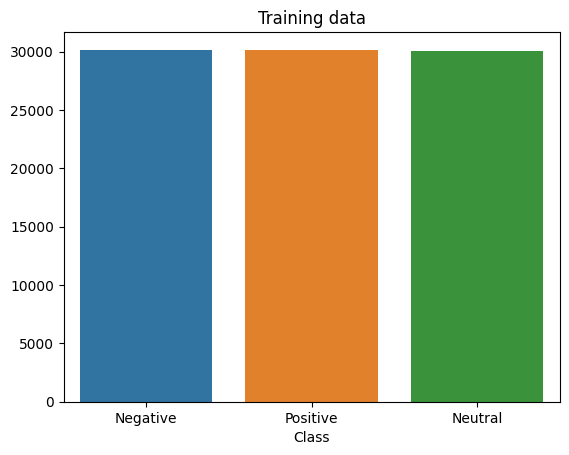

In [ ]:
ax = sns.countplot(data_train, x='sentiment')

ax.set_title('Training data')
ax.set_xlabel('Class')
ax.set_ylabel('')
ax.set_xticklabels(class_index2names.values())

plt.show()

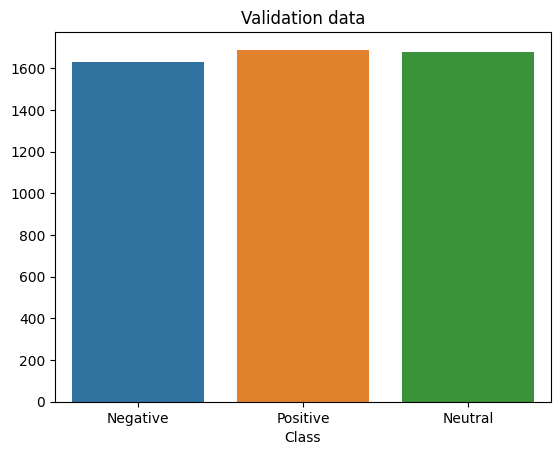

In [ ]:
ax = sns.countplot(data_val, x='sentiment')

ax.set_title('Validation data')
ax.set_xlabel('Class')
ax.set_ylabel('')
ax.set_xticklabels(class_index2names.values())

plt.show()

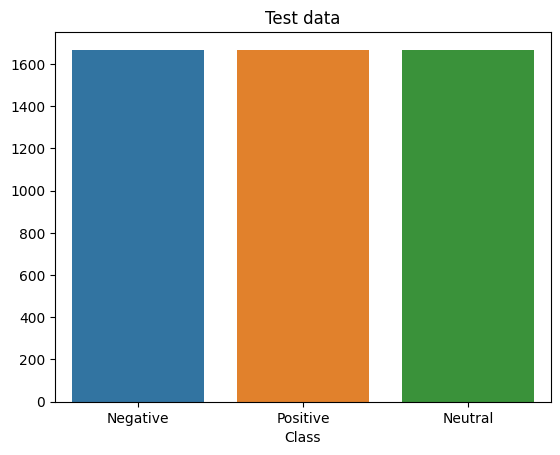

In [ ]:
ax = sns.countplot(data_test, x='sentiment')

ax.set_title('Test data')
ax.set_xlabel('Class')
ax.set_ylabel('')
ax.set_xticklabels(class_index2names.values())

plt.show()

In [ ]:
# Loading the tokenizer BERT
PRE_TRAINED_MODEL_NAME = 'neuralmind/bert-large-portuguese-cased'

tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

In [ ]:
# Auxiliary function to get the sizes of the sentences

tokens_lens = lambda data: [len(tokenizer.encode(tweet, max_length=256, truncation=True))
                            for tweet in data['tweet_text']]

In [ ]:
# train_tokens_lens = tokens_lens(data_train)

# sns.histplot(train_tokens_lens)

# plt.xlim([0, 256])
# plt.xlabel('Token count')

# plt.show()

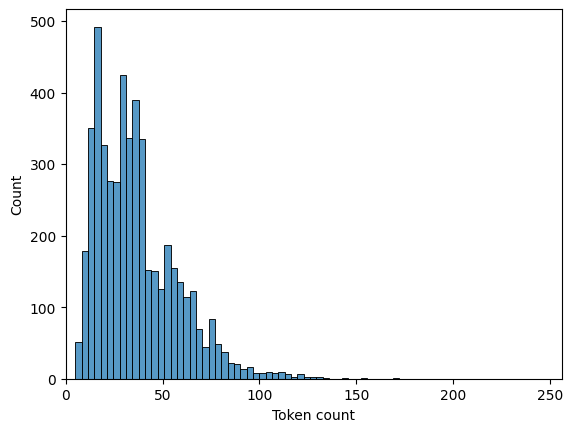

In [ ]:
val_tokens_lens = tokens_lens(data_val)

sns.histplot(val_tokens_lens)

plt.xlim([0, 256])
plt.xlabel('Token count')

plt.show()

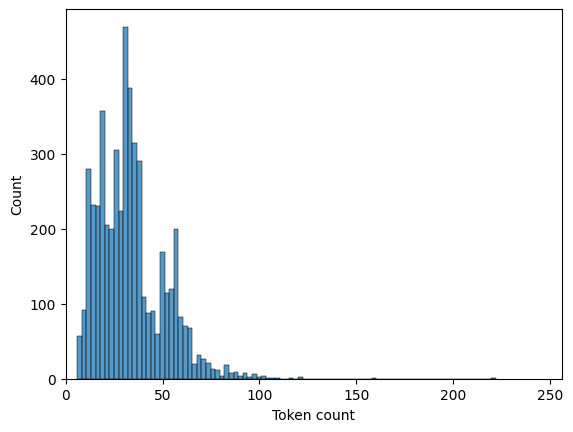

In [ ]:
test_tokens_lens = tokens_lens(data_test)

sns.histplot(test_tokens_lens)

plt.xlim([0, 256])
plt.xlabel('Token count')

plt.show()

Checking the size of sentences to choose a maximum input size:

    Considering the prevalence of sentence sizes, it was obtained -> 125

## PRE-PROCESSING

In [8]:
class clean_data:

  def __init__(self, data, column):
    self.data = data
    self.column = column

    self.pattern_url_1 = r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+'
    self.pattern_url_2 =r'www?.(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+'

    self.pattern_notations = r'@[\w]*'

    self.pattern_hashtag = r'#[\w]*'

    self.subs_emoticon = {r":\)\)|:\)|:D|[Kk]{2,}": "",
                          r":\(|:\(\(": "",
                          r"8\)|:[Pp]": ""}

    self.subs_vic = {r"\s[Qq]\s": " que ",
                          r"\s[Vv]c\s|\svoce\s": " você ",
                          r"\spra\s": " para ",
                          r"\sngm\s": " ninguém ",
                          r"\sto\s|\stô\s": " estou ",
                          r"\s[Nn]\s|\s[Nn]ao\s": " não ",
                          r"\s[Ss]\s": " sim ",
                          r"\s[Ss]o\s": " só ",
                          r"\s{2,}": " "}

    self.pattern_remove_emojis = r'[\U0001F600-\U0001F64F\U0001F300-\U0001F5FF\u2000-\u206F\u2600-\u26FF\u2700-\u27BF\u2B00-\u2BFF\uFE00-\uFE0F]+'

    self.pattern_character_special = r'^[^A-ZÁÉÍÓÚÀÂÊÔÃÕÜÇa-záéíóúàâêôãõüç\d+\-]'
    self.pattern_excessive_character = r'([^\w\s\.])\1{2,}'

  def remove_with_replace(self):

    self.data[self.column] = self.data[self.column].str.replace(self.pattern_url_1, '', regex=True)
    self.data[self.column] = self.data[self.column].str.replace(self.pattern_url_2, '', regex=True)
    self.data[self.column] = self.data[self.column].str.replace(self.pattern_notations, '', regex=True)
    self.data[self.column] = self.data[self.column].str.replace(self.pattern_hashtag, '', regex=True)
    self.data[self.column] = self.data[self.column].replace(self.subs_emoticon, regex=True)
    self.data[self.column] = self.data[self.column].replace(self.subs_vic, regex=True)
    self.data[self.column] = self.data[self.column].str.replace(self.pattern_character_special, '', regex=True)
    self.data[self.column] = self.data[self.column].str.replace(self.pattern_excessive_character, '', regex=True)
    self.data[self.column] = self.data[self.column].str.replace(self.pattern_remove_emojis, '', regex=True)

    self.data[self.column] = self.data[self.column].str.strip()

    return self.data

  def clean(self):
    return self.remove_with_replace()

In [9]:
COLUMN = 'tweet_text'

data_train = clean_data(data_train, COLUMN).clean()
data_test = clean_data(data_test, COLUMN).clean()
data_val = clean_data(data_val, COLUMN).clean()

In [10]:
data_train['tweet_text']

49783                                    Aaaa não neném ((
65737    tu vai na casa da pessoa, toma um banho lá e l...
44073                                     só seguiu o bozo
16882    Eu não fui pq caiu no meu bday e eu escolhi ir...
7472                                        segui de volta
                               ...                        
1682     minha mãe me fala quando ela não gosta das pes...
70665    Com modo online inédito, 'Super Mario Party' t...
97308    Boi Imperador 80 anos de tradição da nossa cul...
95050    Algumas oportunidades não voltam só porque voc...
36034    só queria chegar em casa e encontrar um cel no...
Name: tweet_text, Length: 95000, dtype: object

In [11]:
data_val['tweet_text']

55931                                  Olhaa meu desespero
83509            Governador de MS é alvo de operação da PF
29920    Boa tarde! Poderia, por gentiliza, pedir pro m...
84135    Bolsonaro segue com a maior rejeição, de 43%, ...
34710                     não tinha adesivos na sede do pt
                               ...                        
91657    Eli Corrêa Filho para Deputado Federal e Ramos...
96525    Quero saber pq a insitiu tanto nisso e a globo...
87451    Estadão às 5h: Ciro diz que vitória de Bolsona...
61574           bar : 82ef4eee-be2a-41c8-a503-b8a791e64455
17755    Nah, estou bem sim. Muito obrigada pela preocu...
Name: tweet_text, Length: 5000, dtype: object

## Tokenize and Vocab

In [12]:
nlp = spacy.load("pt_core_news_md")
stop_words = list(spacy.lang.pt.stop_words.STOP_WORDS)
punct = list(string.punctuation)

remove_char = stop_words + punct + [' ','  ', '...', '🤣']

def tokenize(sentence):

  doc = nlp.tokenizer(sentence)
  tokens_list = [s.text for s in doc if s.text not in remove_char]

  return tokens_list

In [13]:
data_train['token'] = data_train['tweet_text'].apply(tokenize)
data_test['token'] = data_test['tweet_text'].apply(tokenize)
data_val['token'] = data_val['tweet_text'].apply(tokenize)

In [14]:
data_train[['tweet_text','token']]

,tweet_text,token
49783,Aaaa não neném ((,"[Aaaa, neném]"
65737,"tu vai na casa da pessoa, toma um banho lá e l...","[casa, pessoa, toma, banho, lava, cabelo, sham..."
44073,só seguiu o bozo,"[seguiu, bozo]"
16882,Eu não fui pq caiu no meu bday e eu escolhi ir...,"[Eu, pq, caiu, bday, escolhi, outro]"
7472,segui de volta,"[segui, volta]"
...,...,...
1682,minha mãe me fala quando ela não gosta das pes...,"[mãe, fala, gosta, pessoas, disse, gostava, ti..."
70665,"Com modo online inédito, 'Super Mario Party' t...","[Com, modo, online, inédito, Super, Mario, Par..."
97308,Boi Imperador 80 anos de tradição da nossa cul...,"[Boi, Imperador, 80, anos, tradição, cultura, ..."
95050,Algumas oportunidades não voltam só porque voc...,"[Algumas, oportunidades, voltam, arrependeu]"


In [15]:
# Procedure get vocab

all_tokens = []

for tokens in data_train['token']:
  all_tokens.extend(tokens)
  
len(all_tokens)

657362

In [16]:
count_tokens = Counter(all_tokens)
count_tokens.most_common(10)

[('dia', 3566),
 ('Eu', 3066),
 ('Bolsonaro', 3005),
 ('vou', 2888),
 ('O', 2790),
 ('gt', 2474),
 ('queria', 2425),
 ('A', 2243),
 ('tá', 2181),
 ('gente', 2098)]

In [17]:
vocab = vocab(count_tokens, min_freq = 5, specials=["<unk>", "<pad>"])
vocab.set_default_index(vocab['<unk>'])

token2id = vocab.get_stoi()

print(token2id)

{'XAU': 16014, 'ESTRELA': 16012, 'BPT': 16011, 'torneira': 16010, 'censurado': 16009, 'incerto': 16006, 'reconhecida': 16004, 'duda': 16002, 'Razer': 15997, 'CNC': 15995, 'SpaceX': 15993, 'Wendell': 15992, '0,5': 15989, '97': 15988, 'chifre': 15987, 'Sono': 15984, 'hq': 15983, 'partidário': 15980, 'wi-fi': 15979, 'aventureiro': 15978, 'japão': 15976, 'funcionalismo': 15973, 'lexa': 15968, '═': 15966, 'floresta': 15961, 'killer': 15956, 'streamer': 15955, 'can': 15954, 'Acc': 15951, 'Libanês': 15950, 'conquistou': 15947, 'dossiê': 15945, 'ingrata': 15936, '1,3': 15931, 'Penha': 15930, 'influentes': 15927, 'converter': 15926, 'chuvinha': 15922, 'Marun': 15920, 'identifiquei': 15919, 'pulso': 15914, 'sucessão': 15906, 'entendemos': 15905, 'Revolução': 15904, 'Aaaaaa': 15902, 'tensa': 15900, 'Stream': 15894, 'DISSE': 15892, 'pesquiso': 15891, 'acender': 15890, 'clã': 15889, 'horrorosa': 15888, 'choveu': 15887, 'defenda': 15886, 'Armazém': 15882, 'fiscalizar': 15881, 'reelegeu': 15880, 'Par

In [18]:
len(vocab)

16017

In [19]:
vocab['catapimbas'], vocab['cachorro'], vocab['<pad>']

(0, 4388, 1)

In [20]:
def tok2vec(tokens):
  return [vocab[s] for s in tokens]

In [21]:
data_train['tok2vec'] = data_train['token'].apply(tok2vec)
data_test['tok2vec'] = data_test['token'].apply(tok2vec)
data_val['tok2vec'] = data_val['token'].apply(tok2vec)

In [22]:
# Removing tweets empty

data_train = data_train[~data_train['tok2vec'].apply(lambda x: len(x) == 0)]
data_test = data_test[~data_test['tok2vec'].apply(lambda x: len(x) == 0)] 
data_val = data_val[~data_val['tok2vec'].apply(lambda x: len(x) == 0)] 


data_train[['tweet_text','token','tok2vec']]

,tweet_text,token,tok2vec
49783,Aaaa não neném ((,"[Aaaa, neném]","[2, 3]"
65737,"tu vai na casa da pessoa, toma um banho lá e l...","[casa, pessoa, toma, banho, lava, cabelo, sham...","[4, 5, 6, 7, 8, 9, 0, 10, 11, 12, 4, 13, 14, 1..."
44073,só seguiu o bozo,"[seguiu, bozo]","[18, 19]"
16882,Eu não fui pq caiu no meu bday e eu escolhi ir...,"[Eu, pq, caiu, bday, escolhi, outro]","[20, 21, 22, 0, 23, 24]"
7472,segui de volta,"[segui, volta]","[25, 26]"
...,...,...,...
1682,minha mãe me fala quando ela não gosta das pes...,"[mãe, fala, gosta, pessoas, disse, gostava, ti...","[1546, 467, 1367, 162, 398, 1395, 291, 10130, ..."
70665,"Com modo online inédito, 'Super Mario Party' t...","[Com, modo, online, inédito, Super, Mario, Par...","[975, 3839, 2420, 7905, 10035, 12426, 0, 871, ..."
97308,Boi Imperador 80 anos de tradição da nossa cul...,"[Boi, Imperador, 80, anos, tradição, cultura, ...","[13711, 0, 1961, 235, 14778, 3937, 0, 276, 460..."
95050,Algumas oportunidades não voltam só porque voc...,"[Algumas, oportunidades, voltam, arrependeu]","[8446, 146, 1041, 15317]"


In [23]:
NUM_CLASSES = len(data_train['sentiment'].unique())
VOCAB_SIZE = len(vocab)
EMBEDDING_SIZE = 320

In [24]:
class TweetDataset(Dataset):
  def __init__(self, dataset):
      self.dataset = dataset
      self.data = dataset['tok2vec']

  def __len__(self):
      return len(self.data)

  def __getitem__(self, index):
      return self.data[index], self.dataset['sentiment'][index]

In [25]:
dataset_train = TweetDataset(data_train.reset_index())
dataset_test = TweetDataset(data_test.reset_index())

In [26]:
def collate_batch(batch):
  
    label_list, vocab_list, offsets = [], [], [0]

    for (_vocab, _label) in batch:
         label_list.append(_label)
         processed_text = torch.tensor(_vocab, dtype=torch.int64)
         vocab_list.append(processed_text)
         offsets.append(processed_text.size(0))

    label_list = torch.tensor(label_list, dtype=torch.int64)
    offsets = torch.tensor(offsets[:-1]).cumsum(dim=0)
    vocab_list = torch.cat(vocab_list)
    
    return vocab_list.to(device),label_list.to(device), offsets.to(device)

### DATASET DATALOADER

In [27]:
# BatchSize
bs = 4
train_dataloader = DataLoader(dataset_train, batch_size=bs, shuffle=True, collate_fn=collate_batch)
test_dataloader = DataLoader(dataset_test, batch_size=bs, shuffle=True, collate_fn=collate_batch)

## MODELO EmbeddingBag

In [28]:
# Architeture

class TweetSentimentClassfier(nn.Module):
    def __init__(self, vocab_size, embedding_size, num_class):
        super(TweetSentimentClassfier, self).__init__() 

        self.embed = nn.EmbeddingBag(vocab_size, embedding_size, sparse=False)
        self.expand = nn.Linear(embedding_size, num_class, bias=False)

    def forward(self, input, offsets):
        embedded = self.embed(input, offsets)
        return self.expand(embedded)

In [29]:
model_EmbBG = model = TweetSentimentClassfier(VOCAB_SIZE, EMBEDDING_SIZE, NUM_CLASSES).to(device)

In [30]:
LR = 1e-4
EPOCHS = 10

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model_EmbBG.parameters(), lr=LR)

In [31]:
def train(dataloader, loss_fn, optimizer):
  model.train()
  
  epoch_loss, epoch_acc = 0.0,0.0

  for idx, (context, label, offsets) in enumerate(dataloader):    
    optimizer.zero_grad()
    out = model_EmbBG(context, offsets)
    _, predicted = torch.max(out, 1)
    loss = loss_fn(out, label)
    epoch_loss += loss.item()

    loss.backward()
    optimizer.step()

    epoch_acc += (out.argmax(1) == label).sum().item()

    if idx % 5000 == 0:
      print(f"| epoch {epoch:3d} | batch {idx}/{len(dataloader)} | train loss: {loss.item():.3} | train accuracy: {(epoch_acc / ((idx + 1) * len(label))):.2f}%")
  
  epoch_loss /= len(dataloader)
  epoch_acc = (epoch_acc / len(dataloader.dataset))

  return epoch_loss, epoch_acc

In [32]:
def evaluate(dataloader, loss_fn):
  model.eval()
  total_acc, total_count = 0,0
  
  with torch.no_grad():
    for idx, (context, label, offsets) in enumerate(dataloader):    
      out = model_EmbBG(context, offsets)
      total_acc += (out.argmax(1) == label).sum().item()
      total_count += label.size(0)
  accu_val = total_acc/total_count
  print('-' * 79)
  print(f'| end of epoch {epoch:3d} | time: {time.time() - epoch_start_time:5.2f}s | '
        f'valid accuracy {accu_val:8.3f} ')
  print('-' * 79)

  return accu_val

In [33]:
running_loss = np.zeros(EPOCHS)
accu_val = np.zeros(EPOCHS)
acc_train = np.zeros(EPOCHS)

for epoch in range(1, EPOCHS + 1):
    epoch_start_time = time.time()
    running_loss[epoch - 1], acc_train[epoch - 1] = train(train_dataloader, loss_fn, optimizer)
    accu_val[epoch - 1] = evaluate(test_dataloader, loss_fn)


| epoch   1 | batch 0/23581 | train loss: 1.09 | train accuracy: 0.25%
| epoch   1 | batch 5000/23581 | train loss: 0.897 | train accuracy: 0.50%
| epoch   1 | batch 10000/23581 | train loss: 0.623 | train accuracy: 0.56%
| epoch   1 | batch 15000/23581 | train loss: 0.985 | train accuracy: 0.59%
| epoch   1 | batch 20000/23581 | train loss: 1.01 | train accuracy: 0.61%
-------------------------------------------------------------------------------
| end of epoch   1 | time: 107.66s | valid accuracy    0.695 
-------------------------------------------------------------------------------
| epoch   2 | batch 0/23581 | train loss: 0.678 | train accuracy: 0.75%
| epoch   2 | batch 5000/23581 | train loss: 0.952 | train accuracy: 0.72%
| epoch   2 | batch 10000/23581 | train loss: 1.04 | train accuracy: 0.72%
| epoch   2 | batch 15000/23581 | train loss: 0.277 | train accuracy: 0.72%
| epoch   2 | batch 20000/23581 | train loss: 0.186 | train accuracy: 0.73%
-------------------------------

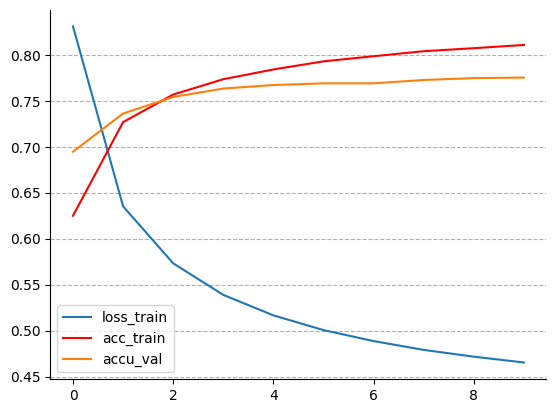

In [34]:
fig, ax = plt.subplots()

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)


plt.plot(running_loss, label='loss_train')
plt.plot(acc_train, label='acc_train', c='r')
plt.plot(accu_val, label='accu_val')
plt.legend(loc="best")
plt.grid(axis = 'y', linestyle = '--')
plt.show()

In [35]:
dataset_val = TweetDataset(data_val.reset_index())
val_dataloader = DataLoader(dataset_val, batch_size=bs, shuffle=True, collate_fn=collate_batch)

print('Checking the results of validation data.')
accu_test = evaluate(val_dataloader, loss_fn)
print(f'test accuracy: {accu_test:.3f}')

Checking the results of validation data.
-------------------------------------------------------------------------------
| end of epoch  10 | time: 177.06s | valid accuracy    0.774 
-------------------------------------------------------------------------------
test accuracy: 0.774


Evaluating the errors in the validation set:

In [36]:
def predict_EmbBAG(tok2vec):
    tok2vec_tensor = torch.tensor(tok2vec, dtype=torch.long).to(device)
    offsets = torch.tensor([0], dtype=torch.long).to(device)
    with torch.no_grad():
        output = model_EmbBG(tok2vec_tensor, offsets)
    return output

In [37]:
testing = data_val[['tweet_text', 'sentiment', 'tok2vec']][100:115]
testing = testing.reset_index()

In [38]:
for t in range(len(testing)):
  print(f'Tweet: {testing["tweet_text"][t]}\n \
        Sentiment: {testing["sentiment"][t]}\n \
        Predict: {predict_EmbBAG(testing["tok2vec"][t])}\n')

Tweet: Aquecendo
         Sentiment: 2
         Predict: tensor([[-0.3364,  0.2831, -1.4310]], device='cuda:0')

Tweet: Lula: Pode ter igual, mas nesse país não tem ninguém melhor do que nós
         Sentiment: 2
         Predict: tensor([[-0.4752,  0.3338,  0.5380]], device='cuda:0')

Tweet: Netflix tá fazendo uma série de Nárnia, eu só estou esperando eles fazerem uma do Percy
         Sentiment: 1
         Predict: tensor([[ 0.2547,  0.4340, -1.2188]], device='cuda:0')

Tweet: Momento forró do show  🥁  em Juazeiro BA
         Sentiment: 2
         Predict: tensor([[-1.2682, -1.1316,  3.0452]], device='cuda:0')

Tweet: ai ai rei
         Sentiment: 0
         Predict: tensor([[ 1.6400,  0.5702, -2.1720]], device='cuda:0')

Tweet: Meu Deputado Estadual não foi eleito
         Sentiment: 0
         Predict: tensor([[ 0.4965, -0.5110,  0.5987]], device='cuda:0')

Tweet: gente (
         Sentiment: 0
         Predict: tensor([[ 2.1332,  0.0894, -3.2528]], device='cuda:0')

Tweet: Um cara

In [39]:
torch.save(model_EmbBG.state_dict(), "modelo_EmbBAG.pt")

In [40]:
def collate_batch(batch):
    contexts = [example[0] for example in batch]
    labels = [example[1] for example in batch]
    padded_contexts = pad_sequence(contexts, batch_first=True, padding_value=1)
    return padded_contexts, torch.tensor(labels).to(device)

## MODELO LSTM

### DATASET DATALOADER

In [41]:
class TweetDatasetLSTM(Dataset):
    def __init__(self, dataset):
        self.dataset = dataset
        self.data = dataset['tok2vec']

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        return torch.tensor(self.data[index]).to(device), self.dataset['sentiment'][index]

In [42]:
dataset_train = TweetDatasetLSTM(data_train.reset_index())
dataset_test = TweetDatasetLSTM(data_test.reset_index())

In [43]:
dataset_train[8]

(tensor([34], device='cuda:0'), 0)

In [45]:
bs = 2

In [46]:
train_dataloader = DataLoader(dataset_train, batch_size=bs, shuffle=True, collate_fn=collate_batch)
test_dataloader = DataLoader(dataset_test, batch_size=bs, shuffle=True, collate_fn=collate_batch)

In [47]:
EMBED_LEN = 224 #120
HIDDEN_DIM = 64
N_LAYERS = 1

class TweetSentimentClassfier_LSTM(nn.Module):
  def __init__(self,  num_class):
    super(TweetSentimentClassfier_LSTM, self).__init__()

    self.embedding_layer = nn.Embedding(VOCAB_SIZE, EMBED_LEN)
    self.lstm = nn.LSTM(input_size=EMBED_LEN, hidden_size=HIDDEN_DIM, num_layers=N_LAYERS, batch_first=True)
    self.dropout = nn.Dropout(0.1)
    self.linear = nn.Linear(HIDDEN_DIM, num_class, bias=True)
    self.softmax = nn.Softmax(dim=1)

  
  def forward(self, input):
    input = input.long()
    embedded = self.embedding_layer(input)
    lstm_out, _ = self.lstm(embedded)
    lstm_out = self.dropout(lstm_out)
    lstm_out = lstm_out[:, -1, :]
    final_out = self.linear(lstm_out)
    final_out = self.softmax(final_out)
    return final_out

In [48]:
model_LSTM = TweetSentimentClassfier_LSTM(NUM_CLASSES).to(device)

In [49]:
LR = 1e-4
EPOCHS = 10

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model_LSTM.parameters(), lr=LR)

In [50]:
def train_lstm(dataloader, loss_fn, optimizer):
  train_loss, train_acc = 0.0,0.0
  total_correct, total_examples = 0,0

  for batch, (context, label) in enumerate(dataloader):
  
    out = model_LSTM(context)
    loss = loss_fn(out, label)
    train_loss += loss.item()

    predictions = out.argmax(dim=1)
    total_correct += (predictions == label).sum().item()
    total_examples += len(label)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if batch % 20000 == 0:
      print(f"| epoch {epoch:3d} | batch {batch}/{len(dataloader)} | train loss: {loss.item():.3} | train accuracy: {(total_correct / total_examples):.2f}%")
  
  train_loss /= len(dataloader.dataset)  # média do loss
  train_acc = total_correct / total_examples  # acurácia total
  return train_loss, train_acc

In [51]:
def test_lstm(dataloader, epoch_start_time):
  total_acc, total_count = 0,0

  with torch.no_grad():
    for batch, (context, label) in enumerate(dataloader):
      out = model_LSTM(context)

      total_acc += (out.argmax(1) == label).sum().item()
      total_count += label.size(0)
  accu_val = total_acc/total_count
  print('-' * 79)
  print(f'| end of epoch {epoch:3d} | time: {time.time() - epoch_start_time:5.2f}s | '
        f'valid accuracy {accu_val:8.3f} ')
  print('-' * 79)

  return accu_val

In [52]:
best_acc = 0

running_loss = np.zeros(EPOCHS)
accu_val = np.zeros(EPOCHS)
acc_train = np.zeros(EPOCHS)

for epoch in range(1, EPOCHS + 1):
    epoch_start_time = time.time()
    running_loss[epoch - 1], acc_train[epoch - 1] = train_lstm(train_dataloader, loss_fn, optimizer)
    accu_val[epoch - 1] = test_lstm(test_dataloader, epoch_start_time)

| epoch   1 | batch 0/47161 | train loss: 1.1 | train accuracy: 0.00%
| epoch   1 | batch 20000/47161 | train loss: 1.05 | train accuracy: 0.56%
| epoch   1 | batch 40000/47161 | train loss: 0.764 | train accuracy: 0.61%
-------------------------------------------------------------------------------
| end of epoch   1 | time: 176.92s | valid accuracy    0.690 
-------------------------------------------------------------------------------
| epoch   2 | batch 0/47161 | train loss: 0.904 | train accuracy: 0.50%
| epoch   2 | batch 20000/47161 | train loss: 0.772 | train accuracy: 0.73%
| epoch   2 | batch 40000/47161 | train loss: 0.636 | train accuracy: 0.73%
-------------------------------------------------------------------------------
| end of epoch   2 | time: 176.36s | valid accuracy    0.731 
-------------------------------------------------------------------------------
| epoch   3 | batch 0/47161 | train loss: 1.11 | train accuracy: 0.50%
| epoch   3 | batch 20000/47161 | train 

In [53]:
import pickle
with open('vocab.pkl', 'wb') as file:
        pickle.dump(vocab, file)

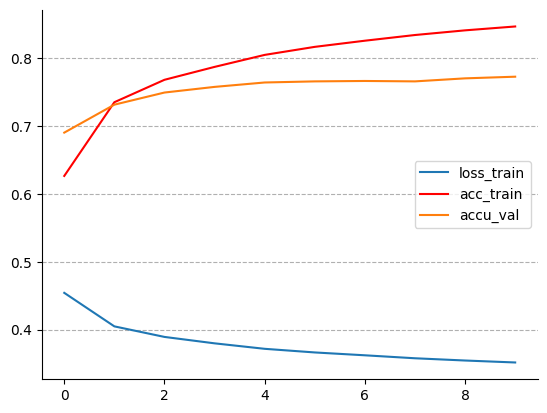

In [54]:
fig, ax = plt.subplots()

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)


plt.plot(running_loss, label='loss_train')
plt.plot(acc_train, label='acc_train', c='r')
plt.plot(accu_val, label='accu_val')
plt.legend(loc="best")
plt.grid(axis = 'y', linestyle = '--')
plt.show()

In [55]:
dataset_val = TweetDatasetLSTM(data_val.reset_index())
val_dataloader = DataLoader(dataset_val, batch_size=bs, shuffle=True, collate_fn=collate_batch)

print('Checking the results of validation data.')
accu_test = test_lstm(val_dataloader, epoch_start_time)
print(f'test accuracy: {accu_test:.3f}')

Checking the results of validation data.
-------------------------------------------------------------------------------
| end of epoch  10 | time: 199.69s | valid accuracy    0.768 
-------------------------------------------------------------------------------
test accuracy: 0.768


### Pipeline para streamlit dos modelos:

In [56]:
def tweet_pipeline(tweet):
  return tok2vec(tokenize(tweet))

In [57]:
tweet_pipeline("Hoje eu vou sair, estou contente.")

[1141, 92, 624, 9710]

In [58]:
def predict_LSTM(tok2vec):
    tok2vec_tensor = torch.LongTensor(tok2vec).to(device)
    tok2vec_tensor = tok2vec_tensor.unsqueeze(0)
    with torch.no_grad():
        output = model_LSTM(tok2vec_tensor)
    return output

In [59]:
predict_LSTM(tweet_pipeline("Hoje eu vou sair, estou contente"))

tensor([[1.5767e-03, 9.9840e-01, 2.3354e-05]], device='cuda:0')

In [60]:
torch.save(model_LSTM.state_dict(), "modelo_lstm.pt")